To look at pySpark's GLM capabilities, we will use the simplest example of a gausian error distribution with an identity link function, which is equivalent to OLS.  In our model we'll try to answer a simple question: how does a change in size (carat) affect a dimaond's price when we control for clarity?  We will test the equation:

    price = a + B*carat + clarity_dummy_vars + e
    
Don't worry about the accuracy of this model specification, or the assumptions behind it; our goal is just to compare pySpark's GLM function to something most users will be more familiar with.  

# Stata Output

Here are the results from Stata.  Note that `clarity` has to be converted to numeric because Stata can't work with strings - this is also true of pySpark.  In Stata this was done using:

    encode clarity, gen(clarity_)
    
Using the `i.` prefix on a column name in the regression command makes Stata split a categorical column out into dummy variables.

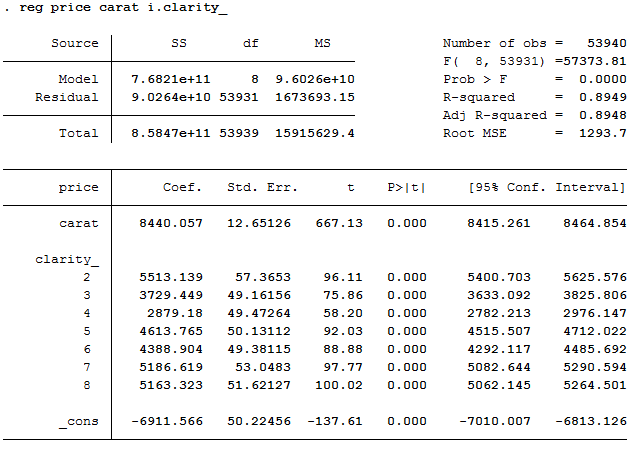

In [2]:
#Here we just use Jupyter's tools to import an image of the Stata output
from IPython.display import Image
Image(filename='stata_reg.PNG')

# pySpark ML Library

Next we will compare the Stata output for this simple model to what we can do in pySpark using their ML library, short for Machine Learning.  The nature of distributed computing makes solving models like this more complicated than most researchers are used to: if your data is distributed across 100 computers and there's no possible way it can all be loaded in one place *how do you invert a matrix?*

There is more than one approch to parameter estimation to address this, but the one used by pySpark 2.0 is called **L-BFGS**, which stands for Limited Memory Broyden–Fletcher–Goldfarb–Shanno.  Explaining how it works is beyond the scope of this simple tutorial, but suffice to say it's an algorithm designed to accomplish parameter estimation in a memory-efficient way that our distributed system can handle.

# Configuring Independent Variables

Before we run the analysis, we must first set up our data for ML to work with.  pySpark ML analysis tools, such as GLM or OLS, require a particular formatting of the independent variables. The tools they offer for this are powerful and flexible, but require the use of an excessive amount of obscure-looking code to accomplish what most social scientists will be used to achieving in one or two simple lines of Stata or SAS code.

The standard formatting **requires exactly two columns** from a dataframe: *a dependent variable column* usually referred to as 'label', and *an independent variable column* usually referred to as 'features'. The dependent variable is simply a column of numerical data; the column for the independent variables must be a *sparse vector*.  

*Optional explanation: A sparse vector is a memory-efficient version of a normal vector where zero values are automatically filled in during calculation for any missing entries - obviously this makes it more efficient the more zeroes there are in your independent variables.  A model that includes dummy variables is therefore ideal.*

In order to skip over a lot of this tedious code, I've written a wrapper that handles it all behind the scenes for you:

In [87]:
#CHANGE TO IMPORT BY LOADING IN BOOTSTRAP

def build_indep_vars(df, independent_vars, categorical_vars=None, keep_intermediate=False):

    """
    Data verification
    df               : DataFrame
    independent_vars : List of column names
    categorical_vars : None or list of column names, e.g. ['col1', 'col2']
    """
    assert(type(df) is pyspark.sql.dataframe.DataFrame), 'pypark_glm: A pySpark dataframe is required as the first argument.'
    assert(type(independent_vars) is list), 'pyspark_glm: List of independent variable column names must be the third argument.'
    for iv in independent_vars:
        assert(type(iv) is str), 'pyspark_glm: Independent variables must be column name strings.'
        assert(iv in df.columns), 'pyspark_glm: Independent variable name is not a dataframe column.'
    if categorical_vars:
        for cv in categorical_vars:
            assert(type(cv) is str), 'pyspark_glm: Categorical variables must be column name strings.'
            assert(cv in df.columns), 'pyspark_glm: Categorical variable name is not a dataframe column.'
            assert(cv in independent_vars), 'pyspark_glm: Categorical variables must be independent variables.'

    """
    Code
    """
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.ml.regression import GeneralizedLinearRegression

    if categorical_vars:
        string_indexer = [StringIndexer(inputCol=x, 
                                        outputCol='{}_index'.format(x))
                          for x in categorical_vars]

        encoder        = [OneHotEncoder(dropLast=True, 
                                        inputCol ='{}_index' .format(x), 
                                        outputCol='{}_vector'.format(x))
                          for x in categorical_vars]

        independent_vars = ['{}_vector'.format(x) if x in categorical_vars else x for x in independent_vars]
    else:
        string_indexer, encoder = [], []

    assembler = VectorAssembler(inputCols=independent_vars, 
                                outputCol='indep_vars')
    pipeline  = Pipeline(stages=string_indexer+encoder+[assembler])
    model = pipeline.fit(df)
    final = model.transform(df)
    
    if not keep_intermediate:
        fcols = [c for c in final.columns if '_index' not in c[-6:] and '_vector' not in c[-7:]]
        final = final[fcols]

    return final

This function, `build_indep_vars`, takes in as arguments a pySpark dataframe, a list of column names for the independent variables, and an optional list of any independent variables that are categorical.  It then handles in the background getting the data in the proper format and expanding the categorical variable columns into multiple columns of dummy variables.  When completed it returns the original dataframe with a new column added to it named 'indep_vars' that contains the properly formatted vector:

In [88]:
df = spark.read.csv('s3://ui-spark-data/diamonds.csv', inferSchema=True, header=True, sep=',')

In [41]:
df.show(5)

+-----+-------+-----+-------+-----+-----+-----+----+----+----+
|carat|    cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+-------+-----+-------+-----+-----+-----+----+----+----+
| 0.23|  Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
| 0.21|Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
| 0.23|   Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
| 0.29|Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
| 0.31|   Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
+-----+-------+-----+-------+-----+-----+-----+----+----+----+
only showing top 5 rows



In [89]:
df = build_indep_vars(df, ['carat', 'clarity'], categorical_vars=['clarity'], keep_intermediate=True)

In [90]:
df.show(5)

+-----+-------+-----+-------+-----+-----+-----+----+----+----+-------------+--------------+--------------------+
|carat|    cut|color|clarity|depth|table|price|   x|   y|   z|clarity_index|clarity_vector|          indep_vars|
+-----+-------+-----+-------+-----+-----+-----+----+----+----+-------------+--------------+--------------------+
| 0.23|  Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|          2.0| (7,[2],[1.0])|(8,[0,3],[0.23,1.0])|
| 0.21|Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|          0.0| (7,[0],[1.0])|(8,[0,1],[0.21,1.0])|
| 0.23|   Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|          3.0| (7,[3],[1.0])|(8,[0,4],[0.23,1.0])|
| 0.29|Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|          1.0| (7,[1],[1.0])|(8,[0,2],[0.29,1.0])|
| 0.31|   Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|          2.0| (7,[2],[1.0])|(8,[0,3],[0.31,1.0])|
+-----+-------+-----+-------+-----+-----+-----+----+----+----+-------------+--------------+-----

We'll skip any more explanation of the contents of the `indep_vars` column, other than to note that it contains all the information necessary for the calculation of the right hand side of our equation.  We can now move on to analysis.  Note once again that we specify the names of the columns that have our **dependent and independent** variables using the common machine learning terms, **label and features**:

In [44]:
from pyspark.ml.regression import GeneralizedLinearRegression

#First we specify the structure of the GLM equation
glm = GeneralizedLinearRegression(family='gaussian', link='identity', labelCol='price', featuresCol='indep_vars')

#Then we fit that model to our data
model = glm.fit(df)

In [47]:
model.params

DenseVector([8440.0573, 3729.449, 4388.9042, 2879.1802, 4613.7646, 5163.3233, 5186.6189, 5513.1392])

In [69]:
model.intercept

-6911.5664005403305

In [83]:
model.summary.pValues

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [91]:
df[['clarity', 'clarity_index']].distinct().show()

+-------+-------------+
|clarity|clarity_index|
+-------+-------------+
|    SI1|          0.0|
|    VS2|          1.0|
|   VVS1|          5.0|
|   VVS2|          4.0|
|     I1|          7.0|
|     IF|          6.0|
|    VS1|          3.0|
|    SI2|          2.0|
+-------+-------------+

